<a href="https://colab.research.google.com/github/kubernetes-world/3666-ANLP-Predicting-ECB-Monetary-Policy/blob/main/LSTM_2_scce_super_cache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

In [ ]:
import os
import pandas as pd
import numpy as np

import gensim
import unicodedata

from itertools import groupby
from unicodedata import category as unicat

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from nltk import word_tokenize, pos_tag
from nltk.chunk import tree2conlltags
from nltk.chunk.regexp import RegexpParser
from nltk.corpus import wordnet as wn
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.utils import pad_sequences

In [3]:
from joblib import Memory
location = 'keyphrase_extractor_cachedir'
memory = Memory(location, verbose=0)

class KeyphraseExtractor(BaseEstimator, TransformerMixin):
    """
    Extract adverbial and adjective phrases, and transform
    documents into lists of these keyphrases, with a total
    keyphrase lexicon limited by the nfeatures parameter
    and a document length limited/padded to doclen
    """
    def __init__(self, nfeatures: int, doclen: int):
        self.grammar = r'KT: {(<RB.> <JJ.*>|<VB.*>|<RB.*>)|(<JJ> <NN.*>)}'
        # self.grammar = r'KT: {(<RB.*> <VB.>|<RB.>|<JJ.> <NN.*>)}'
        # self.grammar = r'KT: {<RB.>|<JJ.>}'
        self.chunker = RegexpParser(self.grammar)
        self.nfeatures = nfeatures
        self.doclen = doclen
        self.normalize = memory.cache(self.normalize)
        self.extract_candidate_phrases = memory.cache(self.extract_candidate_phrases)

    def normalize(self, sent):
        """
        Removes punctuation from a tokenized/tagged sentence and
        lowercases words.
        """
        is_punct = lambda word: all(unicat(c).startswith('P') for c in word)
        sent = filter(lambda t: not is_punct(t[0]), sent)
        sent = map(lambda t: (t[0].lower(), t[1]), sent)
        return list(sent)

    def extract_candidate_phrases(self, sents):
        """
        For a document, parse sentences using our chunker created by
        our grammar, converting the parse tree into a tagged sequence.
        Extract phrases, rejoin with a space, and yield the document
        represented as a list of it's keyphrases.
        """
        result = []
        for i, sent in enumerate(sents):
            tokens = word_tokenize(sent)
            pos_tags = pos_tag(tokens)
            normalized = self.normalize(pos_tags)

            # print(f"\t >> sent #{i}: {sent}")
            # print(f"\t\t >> {normalized}")

            chunks = tree2conlltags(self.chunker.parse(normalized))
            if not chunks or all(chunk[-1] == 'O' for chunk in chunks):
                # print(f"No valid chunks found in sentence: {sent}")
                continue

            phrases = [
                " ".join(word for word, pos, chunk in group).lower()
                for key, group in groupby(
                    chunks, lambda term: term[-1] != 'O'
                ) if key
            ]
            for phrase in phrases:
                # yield phrase
                result.append(phrase)
        return result

    def fit(self, documents, y=None):
        return self

    def get_lexicon(self, keydocs):
        """
        Build a lexicon of size nfeatures
        """
        keyphrases = [keyphrase for doc in keydocs for keyphrase in doc]
        print("Keyphrases:", keyphrases[:5])
        fdist = FreqDist(keyphrases)
        counts = fdist.most_common(self.nfeatures)
        print("Frequency counts:", counts[:5])
        lexicon = [phrase for phrase, count in counts]
        return {phrase: idx+1 for idx, phrase in enumerate(lexicon)}

    def clip(self, keydoc, lexicon):
        """
        Remove keyphrases from documents that aren't in the lexicon
        """
        return [lexicon[keyphrase] for keyphrase in keydoc
            if keyphrase in lexicon.keys()]

    def __list_print_info(self, doc, i):
      print(f">> [#{i}] extract_candidate_phrases...")
      return list(self.extract_candidate_phrases(doc))

    def transform(self, documents):
      print(f">> KeyphraseExtractor.transform: {len(documents)}...")
      docs = [self.__list_print_info(doc, i) for i, doc in enumerate(documents)]
      lexicon = self.get_lexicon(docs)
      clipped = [list(self.clip(doc, lexicon)) for doc in docs]
      return pad_sequences(clipped, maxlen=self.doclen)

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, Input

def create_lstm_model(vocab_size: int, input_length: int, num_classes: int, compile_loss: str):
    model = Sequential([
        Input(shape=(input_length,), name="input_layer"),  # explicit input layer
        Embedding(input_dim=vocab_size, output_dim=128, name="embedding_layer"),
        LSTM(128, return_sequences=True, name="lstm_layer_1"),
        Dropout(0.2, name="dropout_layer_1"),
        LSTM(64, name="lstm_layer_2"),
        Dropout(0.2, name="dropout_layer_2"),
        Dense(num_classes, activation="softmax", name="output_layer")
    ])
    model.compile(optimizer='adam', loss=compile_loss, metrics=['accuracy'])
    return model


In [5]:
class DebugTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        print("Data Shape Before LSTM:", X.shape)
        # print("Sample Data Before LSTM:", X[0])  # print a sample
        return X


# Load prepared data and initialize `X`, `y`

In [6]:

RATE_SPEECHES_TOKENIZED_FILE = 'rate_speeches.sent_tokenize.parquet.gzip'
assert os.path.exists(RATE_SPEECHES_TOKENIZED_FILE), f"file not present: {RATE_SPEECHES_TOKENIZED_FILE}"

rate_speeches = pd.read_parquet(RATE_SPEECHES_TOKENIZED_FILE)
print(f"rate_speeches.shape: {rate_speeches.shape}")


rate_speeches.shape: (3434, 17)


It is acceptable to call `label_encoder.fit_transform(y)` on the entire set of labels (`Direction` values) because `LabelEncoder` is a simple transformation that maps categorical values to numerical labels:

- **It does not learn any information about the dataset beyond the unique classes. However, there are nuances to consider.**


In [7]:
from sklearn.preprocessing import LabelEncoder

X = rate_speeches["extracted_text"]
print(f"X.shape: {X.shape}")

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(rate_speeches["Direction"])  # integer encoding
print(f"y_encoded.shape: {y.shape}")


X.shape: (3434,)
y_encoded.shape: (3434,)


# Choices for `n_splits`

## 5-Fold Cross-Validation:
- Most commonly used.
- Provides a good balance between bias and variance of the performance estimate.

## 10-Fold Cross-Validation:
- Preferred when data is limited and computational cost is acceptable.
- Offers slightly more robust performance estimates but increases computation time.

In [8]:
from sklearn.model_selection import StratifiedKFold

# dynamically determine n_splits based on class distribution
min_class_size = rate_speeches["Direction"].value_counts().min()
print(f"min_class_size: {min_class_size}")

n_splits = min(10, min_class_size)  # use up to 10 splits or the smallest class size
print(f"Using {n_splits}-Fold Cross-Validation")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


min_class_size: 252
Using 10-Fold Cross-Validation


In [9]:
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from joblib import Memory

# set up caching directory
# memory_sparse = Memory(location="cache_directory_sparse", verbose=0)

pipeline_scce = Pipeline([
    ("keyphrase_extractor",
      KeyphraseExtractor(nfeatures=10000, doclen=100)),
    ('debug', DebugTransformer()),
    ("lstm_classifier",
      KerasClassifier(
        build_fn=create_lstm_model,
        vocab_size=10000,
        input_length=100,
        num_classes=3,
        compile_loss='sparse_categorical_crossentropy',
        epochs=10,
        batch_size=32,
        verbose=1)
    )
])


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scores = cross_val_score(pipeline_scce, X_train, y_train, cv=skf, scoring="accuracy")


In [11]:
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {np.mean(scores):.2f}")


Cross-validation scores: [0.78545455 0.8        0.78181818 0.77454545 0.73454545 0.76
 0.76363636 0.82846715 0.78467153 0.76642336]
Mean accuracy: 0.78


In [ ]:

# Final Evaluation on Test Set
pipeline_scce.fit(X_train, y_train)
y_pred = pipeline_scce.predict(X_test)


Confusion Matrix:
[[  5   2  52]
 [  2   2  46]
 [ 23  14 541]]



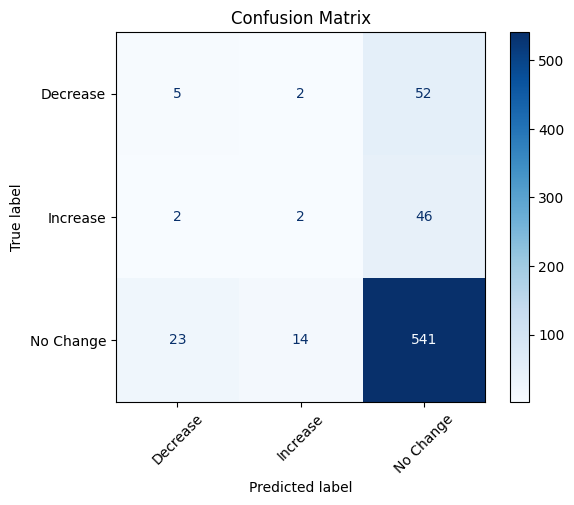


Classification Report:
              precision    recall  f1-score   support

    Decrease       0.17      0.08      0.11        59
    Increase       0.11      0.04      0.06        50
   No Change       0.85      0.94      0.89       578

    accuracy                           0.80       687
   macro avg       0.37      0.35      0.35       687
weighted avg       0.73      0.80      0.76       687



In [13]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
print(cm)

print()
# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))